In [1]:
from astropy.wcs import WCS
from astropy.io import fits 
import astropy.units as u
import matplotlib.pyplot as plt 
import glob 
import numpy as np
import matplotlib.patches as patches
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import scipy.ndimage
import pandas as pd
from photutils import aperture_photometry, SkyCircularAperture
from photutils.aperture import CircularAperture

In [2]:
def mask_out(x,y,data,aperture_size = 7):
    # Mask based on xy coordinates
    apertures = CircularAperture([(x_,y_) for x_,y_ in zip(x,y)], aperture_size)
    masks = apertures.to_mask(method="center")

    # Create a template of all ones.
    blank_data = np.ones(np.shape(data))

    # Zero out where the mask is
    for mask in masks:
        new_mask = mask.to_image(np.shape(data))
        m_x,m_y = np.where(new_mask !=0)
        blank_data[m_x,m_y] = np.nan

    # Multiply the mask by the data
    masked_data = blank_data * data

    # Turn 0's to nans to avoid speckling --> this didnt seem to work, assertion error.
    #masked_data[masked_data == 0] = np.nan

    return masked_data

In [3]:
labels = ["Ra","Dec","Umag","e_Umag",
                     "Bmag","e_Bmag","Vmag","e_Vmag","Imag","e_Imag",
                     "Flag","Jmag","e_Jmag","Hmag","e_Hmag","Ksmag","e_Ksmag"]

df = pd.read_csv('../../Data/Optical/table1_smc.dat',delimiter='\s+',names=labels)
vis = df[df.Vmag < 15]

In [4]:
optical_hdu = fits.open(f'../../Motivation/anna_smc.fits')[0]
co = SkyCoord(vis.Ra,vis.Dec,unit=(u.hourangle,u.deg)).to_pixel(WCS(optical_hdu,naxis=2))

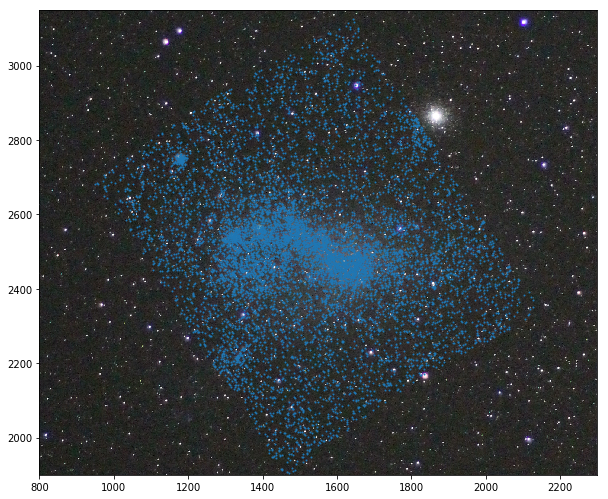

In [6]:
# Plot the image Anna O'Grady took with her Camera of the LMC
# Needs to be transposed in order for the colors to work.
img = fits.open(f'../../Motivation/anna_smc.fits')[0].data.T

# Zoom in on the galaxy
xdim = [800,2300]
ydim = [1900,3150]

# Plot Figure
plt.figure(figsize=(10,10))
plt.imshow(img,origin='lower')
plt.xlim(xdim)
plt.ylim(ydim)
plt.scatter(co[1],co[0],s=1)

In [15]:
# I averaged across the img because there are 3 fields. Seemed unhappy to accept any one slice.
# This takes a while. 
data = np.mean(img,axis=2)
mask = mask_out(co[1],co[0],data)

(1900, 3150)

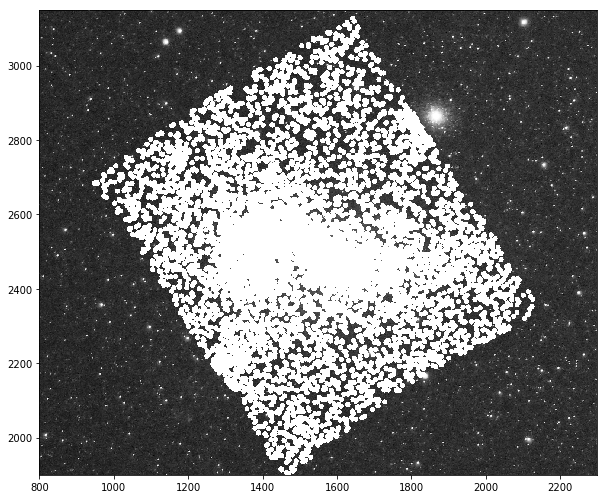

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(mask,origin='lower',cmap='Greys_r')
plt.xlim(xdim)
plt.ylim(ydim)

In [61]:
x = co[1]
y = co[0]
x1 = x[y==min(y)]
y1 = y[y==min(y)]
x2 = x[x==max(x)]
y2 = y[x==max(x)]
x3 = x[y==max(y)]
y3 = y[y==max(y)]
x4 = x[x==min(x)]
y4 = y[x==min(x)]
# Line 1
def line(x1,x2,y1,y2):
    m_1 = (y2-y1)/(x2-x1) 
    x_1 =  np.arange(x1,x2)
    b_1 = y2 - (m_1 * x2)
    return x_1,m_1*x_1+b_1
x_1,y_1 = line(x1,x2,y1,y2)
x_2,y_2 = line(x3,x2,y3,y2)
x_3,y_3 = line(x4,x3,y4,y3)
x_4,y_4 = line(x4,x1,y4,y1)

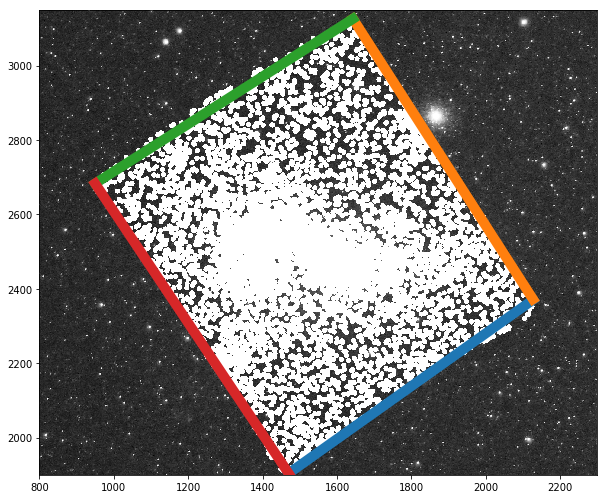

In [95]:
plt.figure(figsize=(10,10))
plt.imshow(mask,origin='lower',cmap='Greys_r')
plt.xlim(xdim)
plt.ylim(ydim)
plt.plot(x_1,y_1,lw=10)
plt.plot(x_2,y_2,lw=10)
plt.plot(x_3,y_3,lw=10)
plt.plot(x_4,y_4,lw=10)

In [93]:
np.shape(data)

(5184, 3456)

In [96]:
# This takes a while too. 
dim_y,dim_x= np.shape(data)
blank = np.ones([dim_y,dim_x])
mask_val = np.nan

def line_eval(x,x1,x2,y1,y2):
    m_1 = (y2-y1)/(x2-x1)
    b_1 = y2 - (m_1 * x2)
    return m_1*x+b_1

for i in np.arange(dim_y):
    for j in np.arange(dim_x):        
        if i < line_eval(j, x4, x1, y4, y1) :
            blank[i,j ] = mask_val
        if i > line_eval(j, x4,x3,y4,y3) :
            blank[i,j ] = mask_val
        if i > line_eval(j, x3,x2,y3,y2) :
            blank[i,j ] = mask_val
        if i < line_eval(j, x1,x2,y1,y2) :
            blank[i,j ] = mask_val


(1900, 3150)

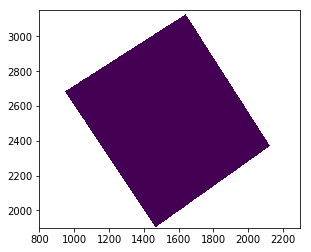

In [76]:
plt.imshow(blank,origin='lower')
plt.xlim(xdim)
plt.ylim(ydim)

(1900, 3150)

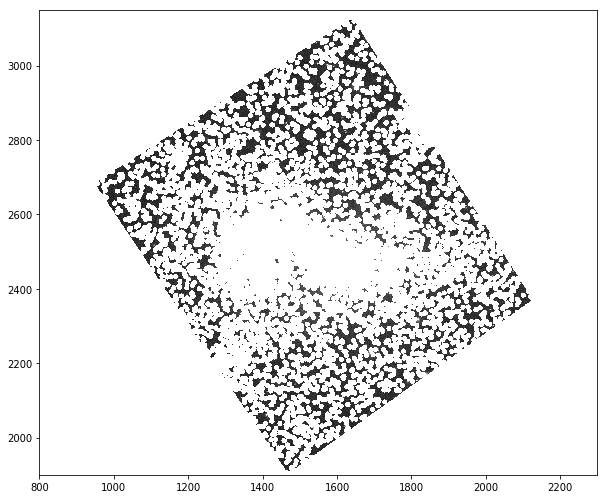

In [78]:
plt.figure(figsize=(10,10))
new_data = mask*blank
plt.imshow(new_data,origin='lower',cmap='Greys_r')
plt.xlim(xdim)
plt.ylim(ydim)

In [79]:
phot = []
y_range = np.arange(dim_y)
x_range = np.arange(dim_x)
phot_x = []
phot_y = []

for i in y_range:
    for j in x_range:
        
        if np.isfinite(new_data[i,j]):
        
            pix_apertures = CircularAperture((j,i), r = 5)
            phot_sum = aperture_photometry(new_data, pix_apertures)['aperture_sum']
            
            if np.isfinite(phot_sum):
                phot.append(phot_sum)
                phot_x.append(j)
                phot_y.append(i)

phot = np.array(phot).flatten()
phot_x = np.array(phot_x).flatten()
phot_y = np.array(phot_y).flatten()

In [107]:
np.max(df.ra)

20.329138648596185

In [111]:
np.max(co_phot_wcs[0])

20.329138648596185

(1900, 3150)

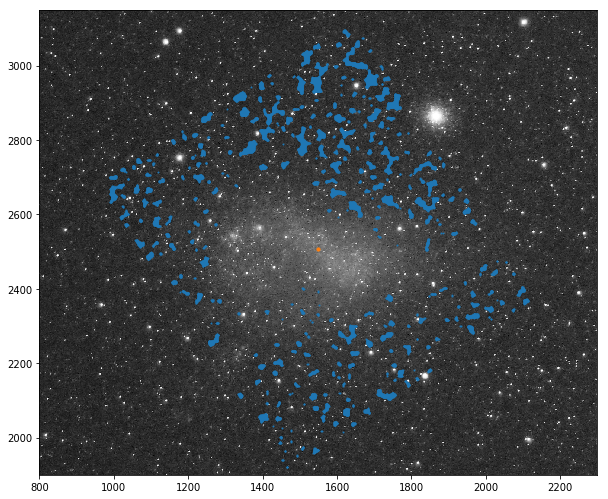

In [128]:
co_phot_wcs = WCS(optical_hdu,naxis=2).all_pix2world(phot_y,phot_x,0)
co_phot = SkyCoord(ra=co_phot_wcs[0],dec=co_phot_wcs[1],unit=u.deg)

center_ra = '00h52m38s'
center_dec = '-72d48m01s'
center_co = SkyCoord(center_ra,center_dec,frame='icrs')
center_y,center_x = center_co.to_pixel(WCS(optical_hdu,naxis=2))

# Plot Figure
plt.figure(figsize=(10,10))
plt.imshow(data,origin='lower',cmap='Greys_r')
plt.scatter(phot_x,phot_y,s=1)
plt.scatter(center_x,center_y,s=10)
plt.xlim(xdim)
plt.ylim(ydim)

In [147]:
dist = center_co.separation(co_phot)
dict = {"ra":co_phot.ra.deg,"dec":co_phot.dec.deg,"photometry":phot,"distance_to_center" : dist.arcminute}
df = pd.DataFrame.from_dict(dict)
df.to_csv('Blank_Spots_SMC.csv')

In [148]:
close = df[df['distance_to_center'] < 45]
cy,cx = SkyCoord(close.ra,close.dec,unit=u.deg).to_pixel(WCS(optical_hdu,naxis=2))
close

,ra,dec,photometry,distance_to_center
4924,14.526679,-73.407507,5266.951497,43.549817
5533,14.202331,-73.261681,4999.808634,33.174791
5551,14.193016,-73.257697,5048.753181,32.886615
5640,14.704603,-73.116760,4867.886028,33.162300
5641,14.690960,-73.119470,4917.345328,33.058149
...,...,...,...,...
9812,11.372136,-72.280938,3779.585668,44.772745
9813,11.358640,-72.283423,3789.938596,44.842642
9814,11.345141,-72.285908,3805.980659,44.914277
9815,11.331639,-72.288391,3831.293444,44.987641


(1900, 3150)

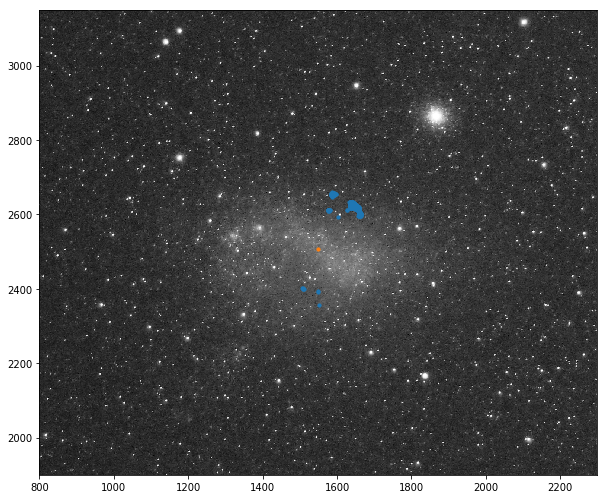

In [145]:
# Plot Figure
plt.figure(figsize=(10,10))
plt.imshow(data,origin='lower',cmap='Greys_r')
plt.scatter(cx,cy,s=10)
plt.scatter(center_x,center_y,s=10)
plt.xlim(xdim)
plt.ylim(ydim)

In [146]:
close.sort_values('distance_to_center')

,ra,dec,photometry,distance_to_center
7345,11.693705,-72.587243,5306.622459,29.098351
7699,11.904985,-72.452372,4408.816152,30.657870
7700,11.891436,-72.454894,4377.725612,30.732701
7701,11.877882,-72.457414,4346.351424,30.810043
7726,11.910147,-72.445768,4433.383052,30.864933
...,...,...,...,...
9779,11.299284,-72.299943,3854.999828,44.941090
8477,10.796982,-72.541713,3590.262111,44.958527
9862,11.377443,-72.274349,3772.980124,44.984809
9815,11.331639,-72.288391,3831.293444,44.987641
